In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map, crop_img
import matplotlib as mpl

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def brain_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/4)
    fig = plt.figure(figsize=(40,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,4,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    fig.subplots_adjust(right=0.7)
    return fig

### Load meshes and masks

In [4]:
rh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl50.vtk'
lh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl50.vtk'
rh_sulc_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'
lh_sulc_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'
mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'

In [5]:
rh_sulc=np.load(rh_sulc_file)
rv, rf, rd = read_vtk(rh_mesh_file)
lh_sulc=np.load(lh_sulc_file)
lv, lf, ld = read_vtk(lh_mesh_file)
mask=np.load(mask_file)

### Load and prep data

In [9]:
lh_file = '/scr/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/lh_group_avg_profiles_smooth_3.npy'
rh_file = '/scr/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/rh_group_avg_profiles_smooth_3.npy'
lh_data = np.load(lh_file)
rh_data = np.load(rh_file)
data = np.concatenate((rh_data[:,3:8],lh_data[:,3:8]))

In [10]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

coeffs, _ = chebapprox(data, 5)

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/numpy/polynomial/chebyshev.py:1785: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


In [11]:
data = coeffs[:,1]
data[mask]=0

### Plot

In [13]:
vmin=0
vmax=100

In [14]:
sns.set_style('white')
cropped_images_lh = []
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                        elev=elev,azim=azim, figsize=(10,9) ,threshold=1e-50, cmap='cubehelix',
                        symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_images_lh.append(crop_img(plot))

In [15]:
sns.set_style('white')
cropped_images_rh = []
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
                        elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='cubehelix',
                        symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_images_rh.append(crop_img(plot))

In [16]:
cropped_img_comb = []
for img in range(int(len(cropped_images_lh)/2)):
    cropped_img_comb.append(cropped_images_lh[2*img])
    cropped_img_comb.append(cropped_images_lh[2*img+1])
    cropped_img_comb.append(cropped_images_rh[2*img])
    cropped_img_comb.append(cropped_images_rh[2*img+1])

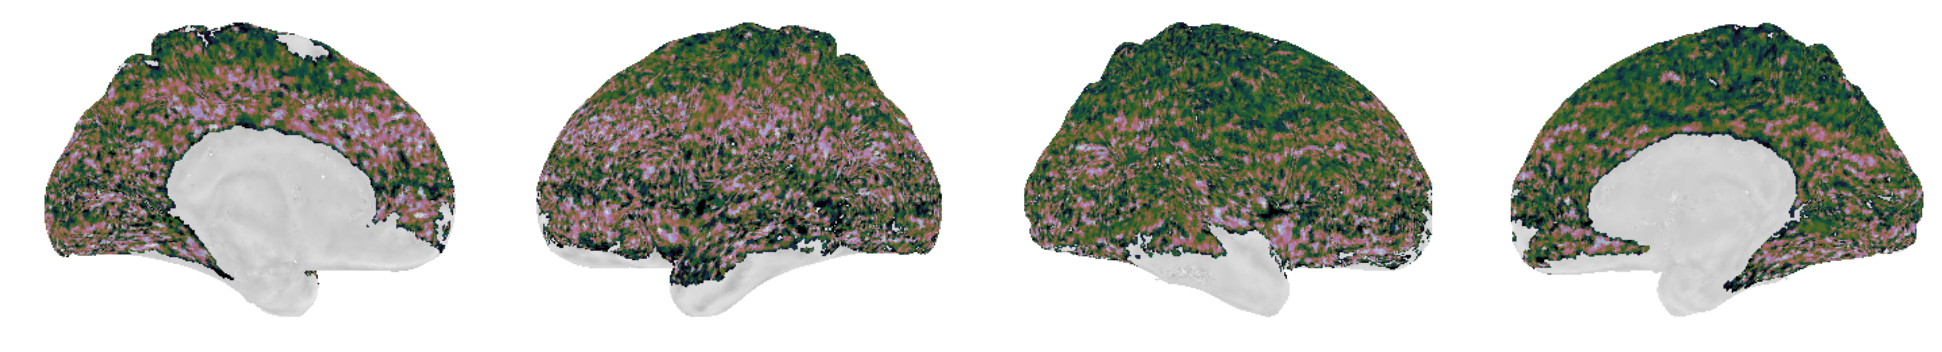

In [22]:
plot=brain_fig(cropped_img_comb)

In [17]:
import pickle
dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'
fullmask=np.load('/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy')
pkl_in = open(dict_file, 'r')
embed_dict = pickle.load(pkl_in)
pkl_in.close()

# normalize vectors
embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, fullmask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

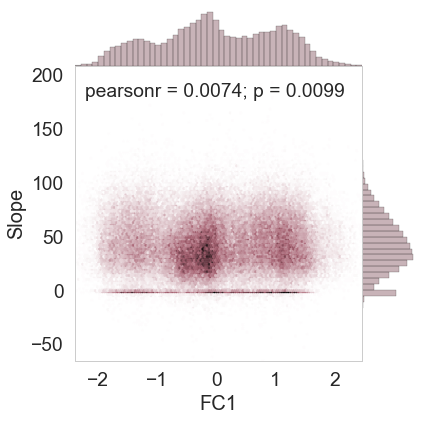

In [23]:
import seaborn as sns
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=1.2)

#xlim = (-2.5, 2.5)
#ylim = (1600, 2350)
#yticks = [1700, 1900,2100, 2300]
scatter_color = sns.xkcd_rgb['brownish purple']
fig = sns.jointplot(-embed[:,0][data!=0], 
                    data[data!=0],space=0,#ylim=ylim,xlim=xlim,
                    kind="hex", size=6, color=scatter_color)
fig.set_axis_labels('FC1', 'Slope', fontsize=20)
#fig.ax_joint.set_yticks(yticks);

### FC / dist correlation

In [7]:
fc_corr = np.load('/scr/ilz3/myelinconnect/new_groupavg/corr/fc_t1_corr.npy')
dist_corr = np.load('/scr/ilz3/myelinconnect/new_groupavg/corr/dist_t1_corr.npy')
resid_corr = np.load('/scr/ilz3/myelinconnect/new_groupavg/corr/fc_t1resid_corr.npy')

In [8]:
fc_corr[mask] = 0
dist_corr[mask] = 0
resid_corr[mask] = 0

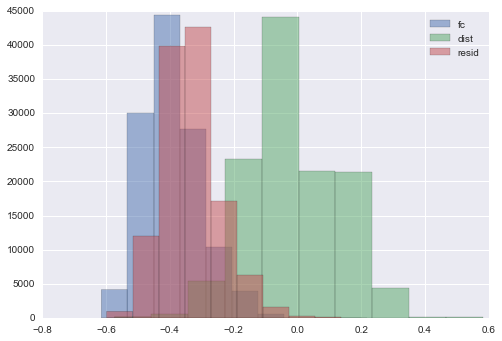

In [9]:
plt.hist(fc_corr[fc_corr!=0], alpha=0.5, label='fc')
plt.hist(dist_corr[dist_corr!=0], alpha=0.5, label='dist')
plt.hist(resid_corr[resid_corr!=0], alpha=0.5, label='resid')
plt.legend()

In [10]:
cropped_img = []
vmin=-0.5
vmax=0.5
sns.set_style('white')
for corr in [fc_corr, dist_corr, resid_corr]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(lv, lf, stat_map=corr[:lv.shape[0]], bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,9) ,threshold=1e-50, cmap='RdBu_r',
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
        cropped_img.append(crop_img(plot))

    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(rv, rf, stat_map=corr[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='RdBu_r',
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
        cropped_img.append(crop_img(plot))

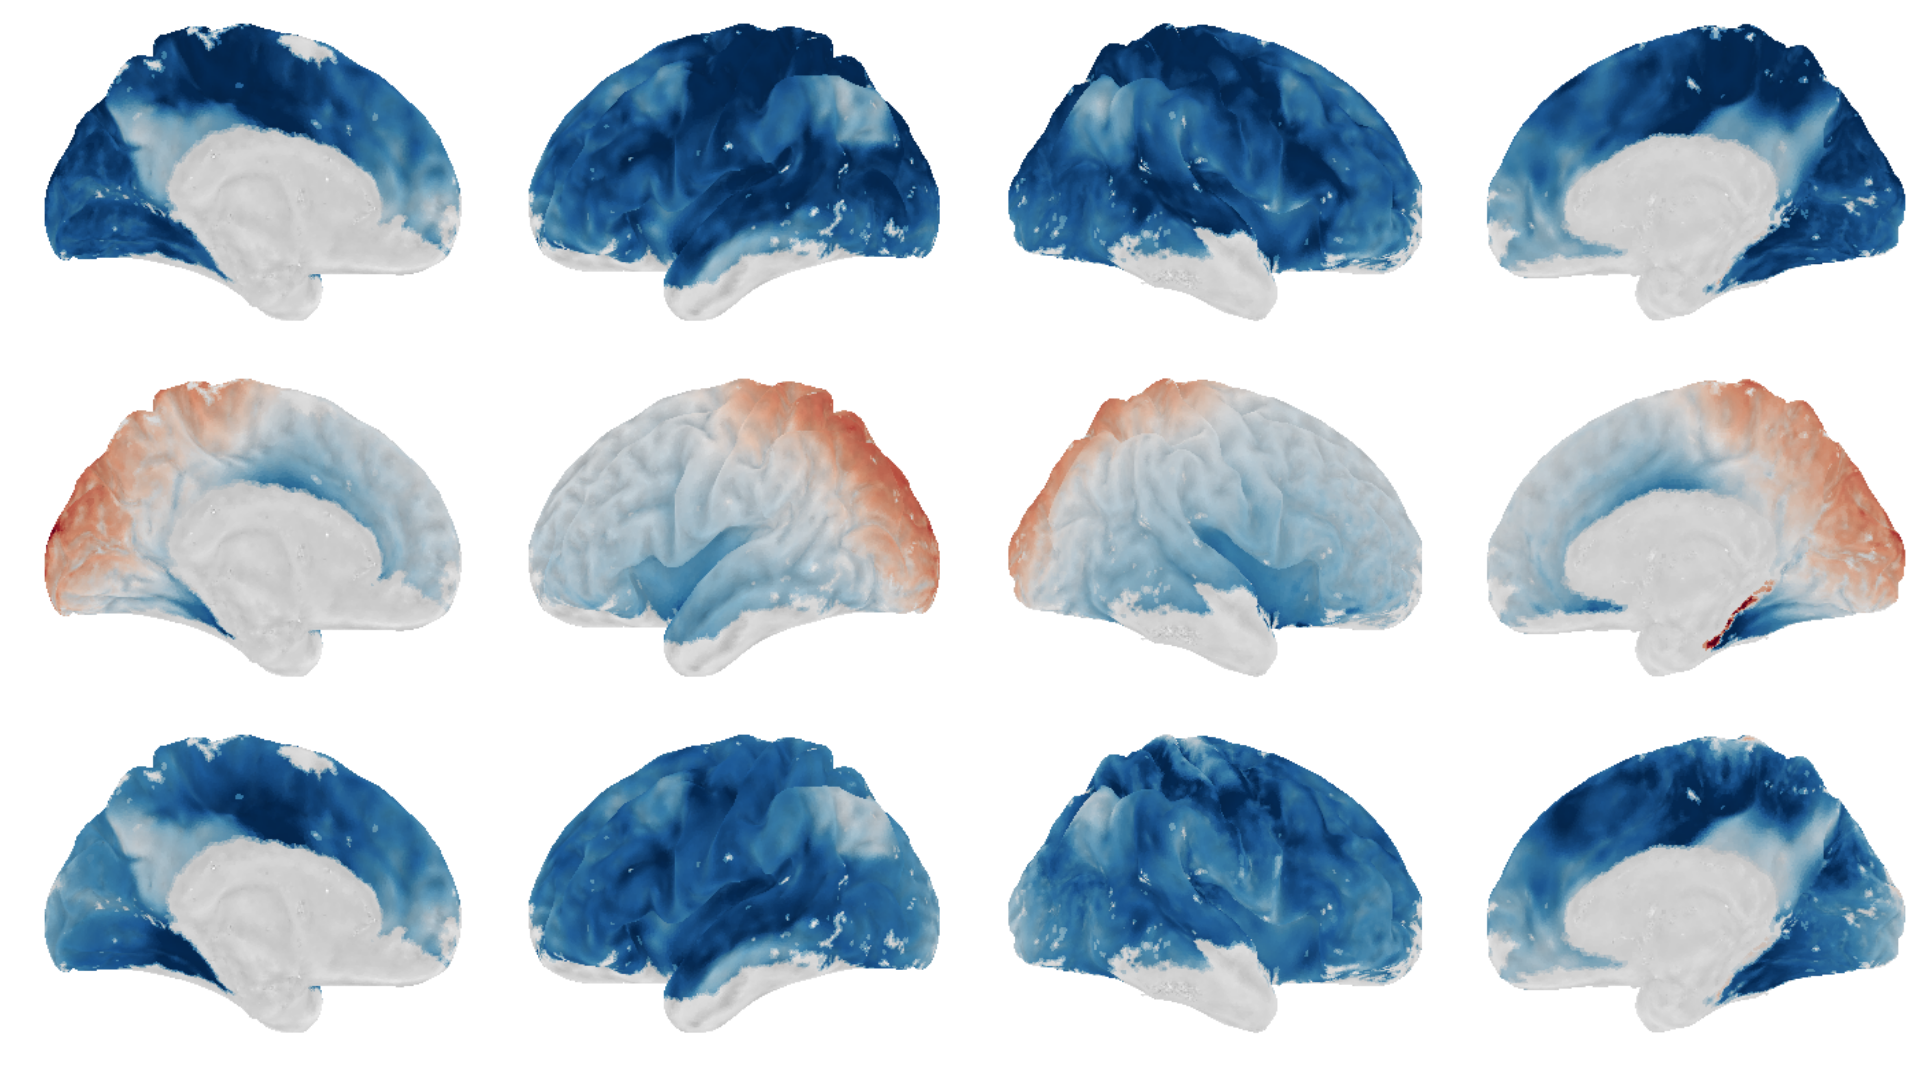

In [11]:
plot=brain_fig(cropped_img)

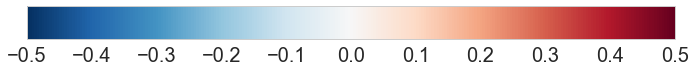

In [12]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=2)
cmap = plt.get_cmap('RdBu_r')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
fig_hcbar = plt.figure(figsize=(10, 3))
ax1 = fig_hcbar.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')